IMPORTS


In [1]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline
import cv2
import glob
import keras
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import datasets,linear_model, preprocessing,utils
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure, show
from keras.layers import Conv1D, Conv2D, MaxPooling2D 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten ,Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

HELPER FUNCTIONS

In [2]:
 #Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

    
def get_outliers_row_idecies(df, name, sd):
    outliers_row_indecies = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    return outliers_row_indecies

# Regression chart.

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


Mounting to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Checking the file imported correctly with columns and rows

In [4]:
path = "/content/drive/My Drive/FINAL DATASET/dataset"
    
filename_train = os.path.join(path,"h1b_kaggle.csv") 

In [5]:
initial_data = pd.read_csv(filename_train,na_values=['NA','?','-'])
print(initial_data.shape)
initial_data.head()
#initial_data = initial_data.drop(' ',axis=1)

(1048575, 11)


,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016,"ST. LOUIS, MISSOURI",-90.199404,38.627003


### **Dropped Unnamed column**

In [6]:
initial_data.rename({"Unnamed: 0":"ID"}, axis="columns", inplace=True)
initial_data = initial_data.drop('ID', axis = 1)
initial_data.head() 

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016,"DENVER, COLORADO",-104.990251,39.739236
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [7]:
initial_data.tail()  

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
1048570,CERTIFIED,LARSEN & TOUBRO INFOTECH LIMITED,COMPUTER PROGRAMMERS,COMPUTER PROGRAMMER,Y,51605.0,2015,"HOUSTON, TEXAS",-95.369803,29.760427
1048571,CERTIFIED,"ALLSCRIPTS HEALTHCARE, LLC","MANAGERS, ALL OTHER","MANAGER, PROFESSIONAL SERVICES",Y,103792.0,2015,"PITTSBURGH, PENNSYLVANIA",-79.995886,40.440625
1048572,CERTIFIED,"HEALTHLINE NETWORKS, INC.","SOFTWARE DEVELOPERS, APPLICATIONS",SENIOR UI ENGINEER,Y,94162.0,2015,"SAN FRANCISCO, CALIFORNIA",-122.419415,37.774929
1048573,CERTIFIED,"THE HACKETT GROUP, INC.",COMPUTER AND INFORMATION SYSTEMS MANAGERS,MANAGER,Y,120619.0,2015,"CHICAGO, ILLINOIS",-87.629798,41.878114
1048574,CERTIFIED,IBM CORPORATION,COMPUTER AND INFORMATION SYSTEMS MANAGERS,CLIENT SERVICES EXECUTIVE,Y,109512.0,2015,"CARY, NORTH CAROLINA",-78.781117,35.791540


In [8]:
#find the sum of all null values  present 
initial_data.isna().sum()

CASE_STATUS               0
EMPLOYER_NAME            19
SOC_NAME                 11
JOB_TITLE                 8
FULL_TIME_POSITION        1
PREVAILING_WAGE           4
YEAR                      0
WORKSITE                  0
lon                   29568
lat                   29568
dtype: int64

In [9]:
# Drop the  null and missing values
initial_data =initial_data.dropna()

In [10]:
initial_data.isna().sum()

CASE_STATUS           0
EMPLOYER_NAME         0
SOC_NAME              0
JOB_TITLE             0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
WORKSITE              0
lon                   0
lat                   0
dtype: int64

In [11]:
print("\nNumber of col/row :")
print("initial_data : ", initial_data.shape)


Number of col/row :
initial_data :  (1018976, 10)


In [12]:
initial_data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016,"DENVER, COLORADO",-104.990251,39.739236
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016,"ST. LOUIS, MISSOURI",-90.199404,38.627003


###  **CASE  STATUS** 

In [13]:
# for countin  values for individual labels in CASE STATUS
print(initial_data['CASE_STATUS'].value_counts())

CERTIFIED              889323
CERTIFIED-WITHDRAWN     81138
WITHDRAWN               34019
DENIED                  14496
Name: CASE_STATUS, dtype: int64


Text(0, 0.5, 'Number of Petetions')

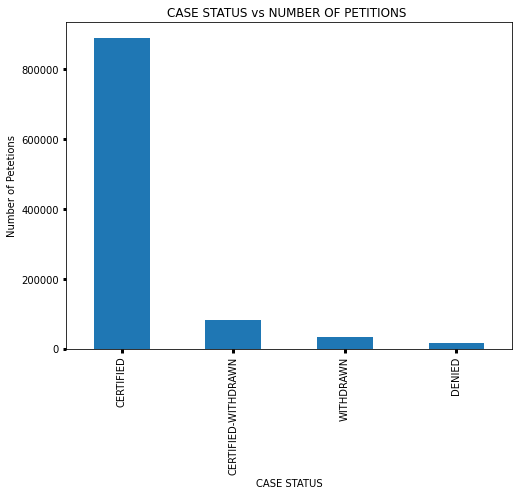

In [14]:
# Plot bar graph for CASE STATUS vs NUMBER OF PETITIONS
fig,ax = plt.subplots(figsize=(8,6))
ax.tick_params(labelsize='medium', width=3)
initial_data.CASE_STATUS.value_counts().plot(kind='bar') 
plt.title("CASE STATUS vs NUMBER OF PETITIONS ")
plt.xlabel('CASE STATUS')  
plt.ylabel('Number of Petetions')

In [15]:
# Dropped the  rows with values of CERTIFIED WITHDRWAWN, WITHDRAWN.   
initial_data = initial_data.drop(initial_data[initial_data.CASE_STATUS == 'WITHDRAWN'].index)
initial_data = initial_data.drop(initial_data[initial_data.CASE_STATUS == 'CERTIFIED-WITHDRAWN'].index)

In [16]:
# Counting the  values for individual labels
print(initial_data['CASE_STATUS'].value_counts())

CERTIFIED    889323
DENIED        14496
Name: CASE_STATUS, dtype: int64


In [17]:
print("\nNumber of col/row :")
print("initial_data : ", initial_data.shape)


Number of col/row :
initial_data :  (903819, 10)


In [18]:
initial_data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
18,CERTIFIED,QUICKLOGIX LLC,CHIEF EXECUTIVES,CEO,Y,187200.0,2016,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108
19,CERTIFIED,"MCCHRYSTAL GROUP, LLC",CHIEF EXECUTIVES,"PRESIDENT, NORTHEAST REGION",Y,241842.0,2016,"ALEXANDRIA, VIRGINIA",-77.046921,38.804835
22,CERTIFIED,"LOMICS, LLC",CHIEF EXECUTIVES,CEO,Y,99986.0,2016,"SAN DIEGO, CALIFORNIA",-117.161084,32.715738
23,CERTIFIED,UC UNIVERSITY HIGH SCHOOL EDUCATION INC.,CHIEF EXECUTIVES,CHIEF FINANCIAL OFFICER,Y,99986.0,2016,"CHULA VISTA, CALIFORNIA",-117.084196,32.640054
25,CERTIFIED,"QUICKLOGIX, INC.",CHIEF EXECUTIVES,CEO,Y,187200.0,2016,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108


In [19]:
#Setting the target class of case status  to 1 and 0 using map.  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html
setting = {'CERTIFIED':1, 'DENIED':0}
initial_data["CASE_STATUS"] = initial_data["CASE_STATUS"].map(setting)

In [20]:
# Counts values for individual labels
print(initial_data['CASE_STATUS'].value_counts())

1    889323
0     14496
Name: CASE_STATUS, dtype: int64


In [21]:
initial_data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
18,1,QUICKLOGIX LLC,CHIEF EXECUTIVES,CEO,Y,187200.0,2016,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108
19,1,"MCCHRYSTAL GROUP, LLC",CHIEF EXECUTIVES,"PRESIDENT, NORTHEAST REGION",Y,241842.0,2016,"ALEXANDRIA, VIRGINIA",-77.046921,38.804835
22,1,"LOMICS, LLC",CHIEF EXECUTIVES,CEO,Y,99986.0,2016,"SAN DIEGO, CALIFORNIA",-117.161084,32.715738
23,1,UC UNIVERSITY HIGH SCHOOL EDUCATION INC.,CHIEF EXECUTIVES,CHIEF FINANCIAL OFFICER,Y,99986.0,2016,"CHULA VISTA, CALIFORNIA",-117.084196,32.640054
25,1,"QUICKLOGIX, INC.",CHIEF EXECUTIVES,CEO,Y,187200.0,2016,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108


Text(0, 0.5, 'Number of Petetions')

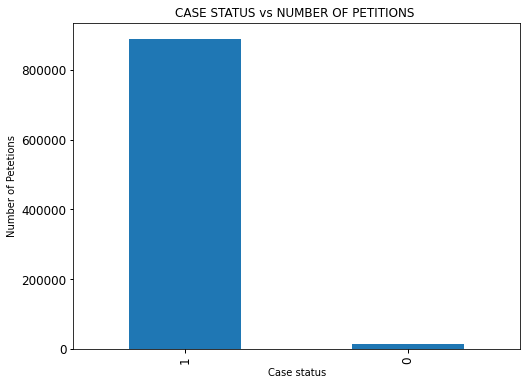

In [22]:
# Plot bar graph for CASE STATUS vs NUMBER OF PETITIONS
fig,ax = plt.subplots(figsize=(8,6))
ax.tick_params(labelsize='large', width=1)
initial_data.CASE_STATUS.value_counts().plot(kind='bar')
plt.title("CASE STATUS vs NUMBER OF PETITIONS ")
plt.xlabel('Case status')  
plt.ylabel('Number of Petetions')

### **EMPLOYER NAME**

In [23]:
print(initial_data['EMPLOYER_NAME'].value_counts())

INFOSYS LIMITED                                         48560
TATA CONSULTANCY SERVICES LIMITED                       22856
WIPRO LIMITED                                           16119
CAPGEMINI AMERICA INC                                   15937
ACCENTURE LLP                                           15757
                                                        ...  
ISRAELI-AMERICAN COUNCIL                                    1
ANDREW LU, CPA                                              1
SETANTA MACHINERY, INC.                                     1
PERSON AREA RUGS LLC                                        1
TRANSUNION RISK AND ALTERNATIVE DATA SOLUTIONS, INC.        1
Name: EMPLOYER_NAME, Length: 88763, dtype: int64


In [24]:
# Converting the column values into  Upper case letters 
initial_data['EMPLOYER_NAME'] = initial_data['EMPLOYER_NAME'].str.upper()

In [25]:
#Printing the first 50 values
initial_data.EMPLOYER_NAME.head(50)

18                              QUICKLOGIX LLC
19                       MCCHRYSTAL GROUP, LLC
22                                 LOMICS, LLC
23    UC UNIVERSITY HIGH SCHOOL EDUCATION INC.
25                            QUICKLOGIX, INC.
27                                  HELLO INC.
28                                  UMBEL CORP
29     PERSPECTIVES OF FREEDOM FOUNDATION, INC
30                                    GTH INC.
31                     THE KRAFT HEINZ COMPANY
32                                 REGED, INC.
33                      VMS COMMUNICATIONS LLC
34     FINLAY EXTRACTS & INGREDIENTS USA, INC.
36                               LABEL INSIGHT
37                    INN AT THE WICKLIFFE LLC
38                  DURHAM SCHOOL SERVICES, LP
39                             PARALLELS, INC.
40                          CB LANSING 300 LLP
41           SOFTTEK INTEGRATION SYSTEMS, INC.
42                               SPARITY, INC.
43                       ADCONION DIRECT, INC.
44           

In [26]:
#made a new column
initial_data['EMPLOYER'] = np.nan
initial_data.shape

(903819, 11)

In [27]:
#grouping similar featues in to common groups
initial_data.EMPLOYER[initial_data['EMPLOYER_NAME'].str.contains('LLC','LIMITED')] = 'LIMITED LIABILTY COMPANY'
initial_data.EMPLOYER[initial_data['EMPLOYER_NAME'].str.contains('INC','CORP')] = 'CORPORATION'
initial_data.EMPLOYER[initial_data['EMPLOYER_NAME'].str.contains('UNIVERSITY','CENTER')] = 'UNIVERSITY AND HEALTH CENTER'
initial_data['EMPLOYER']= initial_data.EMPLOYER.replace(np.nan, 'OTHER', regex=True)

In [28]:
initial_data.EMPLOYER.unique()

array(['LIMITED LIABILTY COMPANY', 'UNIVERSITY AND HEALTH CENTER',
       'CORPORATION', 'OTHER'], dtype=object)

In [29]:
print(initial_data['EMPLOYER'].value_counts())

CORPORATION                     450275
OTHER                           305926
LIMITED LIABILTY COMPANY        121323
UNIVERSITY AND HEALTH CENTER     26295
Name: EMPLOYER, dtype: int64


### **FULL TIME POSITION**

In [30]:
initial_data.FULL_TIME_POSITION.unique()

array(['Y', 'N'], dtype=object)

In [31]:
# Converting the column values into Uppercase
initial_data['FULL_TIME_POSITION'] = initial_data['FULL_TIME_POSITION'].str.upper()

In [32]:
print(initial_data['FULL_TIME_POSITION'].value_counts())

Y    593298
N    310521
Name: FULL_TIME_POSITION, dtype: int64


Text(0, 0.5, 'Number of Petetions')

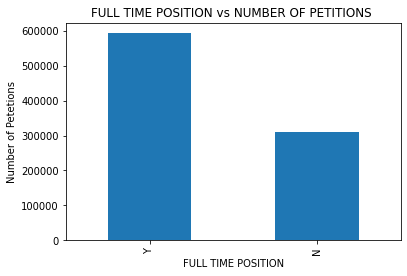

In [33]:
# Plot bar graph for CASE STATUS vs NUMBER OF PETITIONS
initial_data.FULL_TIME_POSITION.value_counts().plot(kind='bar')
plt.title("FULL TIME POSITION vs NUMBER OF PETITIONS ")
plt.xlabel('FULL TIME POSITION')  
plt.ylabel('Number of Petetions')

### **JOB TITLE**

In [ ]:
#Count of values in Job Title
print(initial_data['JOB_TITLE'].value_counts())

PROGRAMMER ANALYST                                        81219
SOFTWARE ENGINEER                                         41203
COMPUTER PROGRAMMER                                       18887
SOFTWARE DEVELOPER                                        18831
SYSTEMS ANALYST                                           18215
                                                          ...  
WEBLOGIC & JAVA, J2EE DEVELOPER                               1
INFORMATION AND SYSTEM MANAGER                                1
DANCE TRAINER/INSTRUCTOR                                      1
INDIGENOUS ADVISOR, SOCIAL POLICY AND PRACTICE PROGRAM        1
SENIOR STRATEGIC PROJECT ENGINEER                             1
Name: JOB_TITLE, Length: 106494, dtype: int64


In [ ]:
# Factorizing the column job title as there were many unique values    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html
initial_data['JOB_TITLE'], uniques = initial_data['JOB_TITLE'].factorize()

In [ ]:
initial_data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat,EMPLOYER
18,1,QUICKLOGIX LLC,CHIEF EXECUTIVES,0,Y,187200.0,2016,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108,LIMITED LIABILTY COMPANY
19,1,"MCCHRYSTAL GROUP, LLC",CHIEF EXECUTIVES,1,Y,241842.0,2016,"ALEXANDRIA, VIRGINIA",-77.046921,38.804835,LIMITED LIABILTY COMPANY
22,1,"LOMICS, LLC",CHIEF EXECUTIVES,0,Y,99986.0,2016,"SAN DIEGO, CALIFORNIA",-117.161084,32.715738,LIMITED LIABILTY COMPANY
23,1,UC UNIVERSITY HIGH SCHOOL EDUCATION INC.,CHIEF EXECUTIVES,2,Y,99986.0,2016,"CHULA VISTA, CALIFORNIA",-117.084196,32.640054,UNIVERSITY AND HEALTH CENTER
25,1,"QUICKLOGIX, INC.",CHIEF EXECUTIVES,0,Y,187200.0,2016,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108,CORPORATION


### **SOC_NAME**

In [ ]:
initial_data['SOC_NAME'].value_counts().head(100)

SOFTWARE DEVELOPERS, APPLICATIONS           159934
COMPUTER SYSTEMS ANALYSTS                   157824
COMPUTER PROGRAMMERS                        129020
COMPUTER OCCUPATIONS, ALL OTHER              80865
SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE        28606
                                             ...  
ENVIRONMENTAL ENGINEERS                        626
COMPUTER SCIENCE TEACHERS, POSTSECONDARY       625
MICROBIOLOGISTS                                564
MATHEMATICIANS                                 558
ART DIRECTORS                                  547
Name: SOC_NAME, Length: 100, dtype: int64

In [ ]:
# Convert columns values in lowercase
initial_data['SOC_NAME'] = initial_data['SOC_NAME'].str.lower()

In [ ]:
initial_data['SOC_NAME'].value_counts().head(100)

software developers, applications           159934
computer systems analysts                   157824
computer programmers                        129020
computer occupations, all other              80865
software developers, systems software        28606
                                             ...  
environmental engineers                        626
computer science teachers, postsecondary       625
microbiologists                                564
mathematicians                                 558
art directors                                  547
Name: SOC_NAME, Length: 100, dtype: int64

In [ ]:
# Adding new column dividing the values into different classes according to the top 35 SOC names
initial_data['OCCUPATION_NAME'] = np.nan

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('engineers','architect')] = 'Engineering'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('information','technician')] = 'Engineering'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('chemists','physicist')] = 'Sciences'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('biochemists','biophysicists')] = 'Sciences'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('biology','scientists')] = 'Sciences'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('research')] = 'Sciences'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('computer','database')] = 'Software'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('software','developers')] = 'Software'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('math','statistic')] = 'Mathematics'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('statisticians','logisticians')] = 'Mathematics'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('principal','linguist')] = 'Education'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('professor','Teach')] = 'Education'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('medical','doctor')] = 'Medical'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('physician','dentist')] = 'Medical'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('health','Physical Therapists')] = 'Medical'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('surgeon','nurse')] = 'Medical'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('biological','clinical research')] = 'Sciences'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('public relation','managers')] = 'Management'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('management','operation')] = 'Management'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('chief','plan')] = 'Management'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('executive')] = 'Marketing'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('advertis','marketing')] = 'Marketing'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('promotion','market research')] = 'Occupation'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('business','business analyst')] = 'Bussiness '
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('business systems analyst')] = 'Bussiness'

initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('accountants','finance')] = 'Finance'
initial_data.OCCUPATION_NAME[initial_data['SOC_NAME'].str.contains('financial')] = 'Finance'

initial_data['OCCUPATION_NAME']= initial_data.OCCUPATION_NAME.replace(np.nan, 'Others', regex=True)

In [ ]:
initial_data.OCCUPATION_NAME.value_counts()

Software       626376
Others         104543
Engineering     44908
Finance         35972
Sciences        35684
Management      24088
Medical         20307
Mathematics      7213
Bussiness        3415
Marketing         804
Occupation        509
Name: OCCUPATION_NAME, dtype: int64

Text(0.5, 0, 'Number of Petetions')

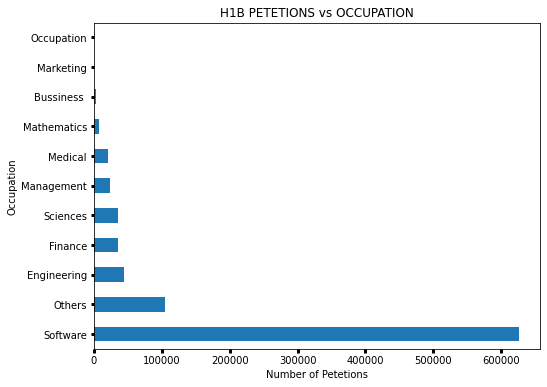

In [ ]:
#Plotting 
fig,ax = plt.subplots(figsize=(8,6))
ax.tick_params(labelsize='medium', width=3)
initial_data.OCCUPATION_NAME.value_counts().plot.barh(x='PETETIONS', y='OCCUPATION_NAME')
plt.title("H1B PETETIONS vs OCCUPATION")
plt.ylabel('Occupation')  
plt.xlabel('Number of Petetions')

### **FULL_TIME_POSITION**

In [ ]:
 print(initial_data['FULL_TIME_POSITION'].value_counts())

Y    593298
N    310521
Name: FULL_TIME_POSITION, dtype: int64


### **YEAR**

In [ ]:
initial_data.YEAR.value_counts()

2016    562315
2015    341504
Name: YEAR, dtype: int64

In [ ]:
initial_data.YEAR.unique()

array([2016, 2015])

Text(0, 0.5, 'Number of Petetions')

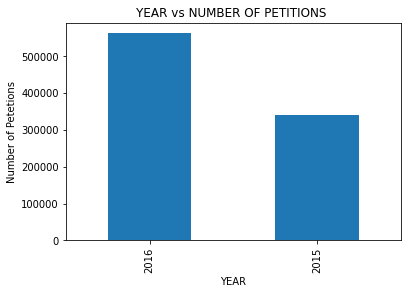

In [ ]:
# Plot bar graph for CASE STATUS vs NUMBER OF PETITIONS
initial_data.YEAR.value_counts().plot(kind='bar')
plt.title("YEAR vs NUMBER OF PETITIONS ")
plt.xlabel('YEAR')  
plt.ylabel('Number of Petetions')

### **WORKSITE**

In [ ]:
initial_data.WORKSITE.value_counts()

NEW YORK, NEW YORK           53844
HOUSTON, TEXAS               24263
SAN FRANCISCO, CALIFORNIA    21522
ATLANTA, GEORGIA             18902
CHICAGO, ILLINOIS            17018
                             ...  
KEW GARDENS, NEW YORK            1
PISCATWAY, NEW JERSEY            1
MASSAPEQUA, NEW YORK             1
SPRING CITY, PENNSYLVANIA        1
WILLOUGHBY HILLS, OHIO           1
Name: WORKSITE, Length: 2480, dtype: int64

In [ ]:
initial_data.WORKSITE.unique()

array(['SANTA CLARA, CALIFORNIA', 'ALEXANDRIA, VIRGINIA',
       'SAN DIEGO, CALIFORNIA', ..., 'PISCATWAY, NEW JERSEY',
       'WILLOUGHBY HILLS, OHIO', 'SPRING CITY, PENNSYLVANIA'],
      dtype=object)

Text(0, 0.5, 'Number of Petetions')

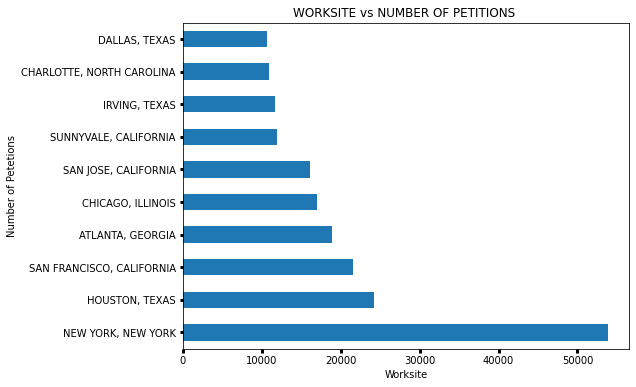

In [ ]:
# Plot bar graph for CASE STATUS vs NUMBER OF PETITIONS 
fig,ax = plt.subplots(figsize=(8,6))
ax.tick_params(labelsize='medium', width=3) 
initial_data.WORKSITE.value_counts().head(10).plot.barh(x='PETETIONS', y='OCCUPATION_NAME')
plt.title("WORKSITE vs NUMBER OF PETITIONS ")
plt.xlabel('Worksite')  
plt.ylabel('Number of Petetions')

In [ ]:
#Series.str.split(*args, **kwargs)
initial_data.WORKSITE.str.split(',').str[-1]
initial_data['WORKSITE'] = initial_data.WORKSITE.str.split(',').str[-1]

In [ ]:
#To find mean min,std,max, and min value 
initial_data.describe()

,CASE_STATUS,JOB_TITLE,PREVAILING_WAGE,YEAR,lon,lat
count,903819.000000,903819.000000,9.038190e+05,903819.000000,903819.000000,903819.000000
mean,0.983961,23475.771362,8.893415e+04,2015.622154,-92.077833,38.174556
std,0.125624,23451.887802,1.641055e+06,0.484849,19.348491,4.611494
min,0.000000,0.000000,0.000000e+00,2015.000000,-157.858333,13.437192
25%,1.000000,4397.000000,5.680500e+04,2015.000000,-111.841250,34.147785
50%,1.000000,18934.000000,6.662200e+04,2016.000000,-86.158068,39.099727
75%,1.000000,29562.000000,8.249280e+04,2016.000000,-75.539788,40.885835
max,1.000000,106493.000000,3.291392e+08,2016.000000,145.729789,64.837778


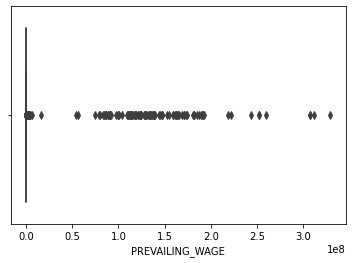

In [ ]:
#To check outliers through boxplot
import seaborn as sns
sns.boxplot(x=initial_data['PREVAILING_WAGE'])

### **PREVAILING_WAGE**

In [ ]:
#setting the wage range between 90 and 10 percentile
max_value, min_value = initial_data.PREVAILING_WAGE.quantile([0.90,0.10])
min_value , max_value

(47944.0, 102898.0)

In [ ]:
#setting the maximum and minimum values
initial_data=initial_data[initial_data['PREVAILING_WAGE']>min_value]
initial_data=initial_data[initial_data['PREVAILING_WAGE']<max_value]

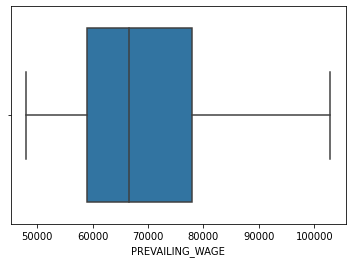

In [ ]:
import seaborn as sns
sns.boxplot(x=initial_data['PREVAILING_WAGE'])

In [ ]:
print(initial_data.shape)
initial_data.head()

(722978, 12)


,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat,EMPLOYER,OCCUPATION_NAME
22,1,"LOMICS, LLC",chief executives,0,Y,99986.00,2016,CALIFORNIA,-117.161084,32.715738,LIMITED LIABILTY COMPANY,Marketing
23,1,UC UNIVERSITY HIGH SCHOOL EDUCATION INC.,chief executives,2,Y,99986.00,2016,CALIFORNIA,-117.084196,32.640054,UNIVERSITY AND HEALTH CENTER,Marketing
29,1,"PERSPECTIVES OF FREEDOM FOUNDATION, INC",chief executives,5,Y,95295.98,2016,FLORIDA,-80.399775,26.100365,CORPORATION,Marketing
34,1,"FINLAY EXTRACTS & INGREDIENTS USA, INC.",chief executives,9,Y,98550.00,2016,RHODE ISLAND,-71.441810,41.911012,CORPORATION,Marketing
37,1,INN AT THE WICKLIFFE LLC,chief executives,10,N,52416.00,2016,OHIO,-81.453449,41.605327,LIMITED LIABILTY COMPANY,Marketing


In [ ]:
#Dropping the columns which are not required
initial_data = initial_data.drop('EMPLOYER_NAME', axis = 1)
initial_data = initial_data.drop('SOC_NAME', axis = 1)
initial_data = initial_data.drop('lon', axis = 1)
initial_data = initial_data.drop('lat', axis = 1)

In [ ]:
print(initial_data.shape)
initial_data.head()

(722978, 8)


,CASE_STATUS,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,EMPLOYER,OCCUPATION_NAME
22,1,0,Y,99986.00,2016,CALIFORNIA,LIMITED LIABILTY COMPANY,Marketing
23,1,2,Y,99986.00,2016,CALIFORNIA,UNIVERSITY AND HEALTH CENTER,Marketing
29,1,5,Y,95295.98,2016,FLORIDA,CORPORATION,Marketing
34,1,9,Y,98550.00,2016,RHODE ISLAND,CORPORATION,Marketing
37,1,10,N,52416.00,2016,OHIO,LIMITED LIABILTY COMPANY,Marketing


In [ ]:
#Checking the date type of columns
initial_data.dtypes

CASE_STATUS             int64
JOB_TITLE               int64
FULL_TIME_POSITION     object
PREVAILING_WAGE       float64
YEAR                    int64
WORKSITE               object
EMPLOYER               object
OCCUPATION_NAME        object
dtype: object

### **ONE HOT ENCODING**

In [ ]:
#Encoding categorical features into Numeric form
encode_text_dummy(initial_data,'FULL_TIME_POSITION')
encode_text_dummy(initial_data,'YEAR')
encode_text_dummy(initial_data,'EMPLOYER')
encode_text_dummy(initial_data,'OCCUPATION_NAME')
encode_text_dummy(initial_data,'WORKSITE')

In [ ]:
print(initial_data.shape)
initial_data.head()

(722978, 75)


,CASE_STATUS,JOB_TITLE,PREVAILING_WAGE,FULL_TIME_POSITION-N,FULL_TIME_POSITION-Y,YEAR-2015,YEAR-2016,EMPLOYER-CORPORATION,EMPLOYER-LIMITED LIABILTY COMPANY,EMPLOYER-OTHER,EMPLOYER-UNIVERSITY AND HEALTH CENTER,OCCUPATION_NAME-Bussiness,OCCUPATION_NAME-Engineering,OCCUPATION_NAME-Finance,OCCUPATION_NAME-Management,OCCUPATION_NAME-Marketing,OCCUPATION_NAME-Mathematics,OCCUPATION_NAME-Medical,OCCUPATION_NAME-Occupation,OCCUPATION_NAME-Others,OCCUPATION_NAME-Sciences,OCCUPATION_NAME-Software,WORKSITE- ALABAMA,WORKSITE- ALASKA,WORKSITE- ARIZONA,WORKSITE- ARKANSAS,WORKSITE- CALIFORNIA,WORKSITE- COLORADO,WORKSITE- CONNECTICUT,WORKSITE- DELAWARE,WORKSITE- DISTRICT OF COLUMBIA,WORKSITE- FLORIDA,WORKSITE- GEORGIA,WORKSITE- HAWAII,WORKSITE- IDAHO,WORKSITE- ILLINOIS,WORKSITE- INDIANA,WORKSITE- IOWA,WORKSITE- KANSAS,WORKSITE- KENTUCKY,WORKSITE- LOUISIANA,WORKSITE- MAINE,WORKSITE- MARYLAND,WORKSITE- MASSACHUSETTS,WORKSITE- MICHIGAN,WORKSITE- MINNESOTA,WORKSITE- MISSISSIPPI,WORKSITE- MISSOURI,WORKSITE- MONTANA,WORKSITE- NA,WORKSITE- NEBRASKA,WORKSITE- NEVADA,WORKSITE- NEW HAMPSHIRE,WORKSITE- NEW JERSEY,WORKSITE- NEW MEXICO,WORKSITE- NEW YORK,WORKSITE- NORTH CAROLINA,WORKSITE- NORTH DAKOTA,WORKSITE- OHIO,WORKSITE- OKLAHOMA,WORKSITE- OREGON,WORKSITE- PENNSYLVANIA,WORKSITE- PUERTO RICO,WORKSITE- RHODE ISLAND,WORKSITE- SOUTH CAROLINA,WORKSITE- SOUTH DAKOTA,WORKSITE- TENNESSEE,WORKSITE- TEXAS,WORKSITE- UTAH,WORKSITE- VERMONT,WORKSITE- VIRGINIA,WORKSITE- WASHINGTON,WORKSITE- WEST VIRGINIA,WORKSITE- WISCONSIN,WORKSITE- WYOMING
22,1,0,99986.00,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,1,2,99986.00,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,1,5,95295.98,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,1,9,98550.00,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
37,1,10,52416.00,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Splitting into X and Y**

In [ ]:
x = initial_data.drop('CASE_STATUS', axis=1)
y = initial_data.CASE_STATUS

In [ ]:
print(x.head())
x.shape

    JOB_TITLE  PREVAILING_WAGE  ...  WORKSITE- WISCONSIN  WORKSITE- WYOMING
22          0         99986.00  ...                    0                  0
23          2         99986.00  ...                    0                  0
29          5         95295.98  ...                    0                  0
34          9         98550.00  ...                    0                  0
37         10         52416.00  ...                    0                  0

[5 rows x 74 columns]


(722978, 74)

In [ ]:
print(y.head())
y.shape

22    1
23    1
29    1
34    1
37    1
Name: CASE_STATUS, dtype: int64


(722978,)

In [ ]:
# Applying StandardScalar preprocessing on the x data
from sklearn.preprocessing import StandardScaler
normalize = StandardScaler()
x = normalize.fit_transform(x)
x

array([[-1.00650817,  2.25603403, -0.73604418, ..., -0.01903999,
        -0.10638549, -0.00991033],
       [-1.00641682,  2.25603403, -0.73604418, ..., -0.01903999,
        -0.10638549, -0.00991033],
       [-1.00627978,  1.91034227, -0.73604418, ..., -0.01903999,
        -0.10638549, -0.00991033],
       ...,
       [-0.14164201, -0.84087918, -0.73604418, ..., -0.01903999,
        -0.10638549, -0.00991033],
       [-0.14378888, -1.31003028, -0.73604418, ..., -0.01903999,
        -0.10638549, -0.00991033],
       [ 0.45998216,  1.82675893, -0.73604418, ..., -0.01903999,
        -0.10638549, -0.00991033]])

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y))

Counter({1: 713398, 0: 9580})


In [ ]:
# for imbalanced data I Applied NearMiss downsampling technique https://youtu.be/Ti8SbfFecuc
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
x, y = nr.fit_sample(x, y)

In [ ]:
Counter(y)

Counter({0: 9580, 1: 9580})

In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
x.shape

(19160, 74)

In [ ]:
y.shape

(19160,)

### **Split Train and Test data**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=42)

In [ ]:
print("\nNumber of col/row currently:")
print('X Training: ', x_train.shape)
print('Y Training: ', y_train.shape)
print('X Testing: ', x_test.shape)
print('Y Testing: ', y_test.shape)


Number of col/row currently:
X Training:  (13412, 74)
Y Training:  (13412,)
X Testing:  (5748, 74)
Y Testing:  (5748,)


In [ ]:
y_test

array([1, 1, 0, ..., 0, 1, 1])

### **Neural networks**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=2, mode='min')
checkpoint = ModelCheckpoint(filepath='.weights.hdf5', verbose=1, save_best_only=True)
model.fit(x_train,y_train,verbose=2,epochs=200, batch_size=20,  callbacks=[monitor, checkpoint], validation_split=0.25)

model.summary()

#print(x_test)
y_pred = model.predict(x_test)
y_newpred = (y_pred > 0.5)

print(y_test)

score_test = np.sqrt(metrics.mean_squared_error(y_newpred,y_test))
print("Score_test (RMSE): {}".format(score_test))    

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.22929, saving model to .weights.hdf5
503/503 - 2s - loss: 0.3063 - accuracy: 0.9068 - val_loss: 0.2293 - val_accuracy: 0.9314
Epoch 2/200

Epoch 00002: val_loss improved from 0.22929 to 0.22409, saving model to .weights.hdf5
503/503 - 1s - loss: 0.2348 - accuracy: 0.9306 - val_loss: 0.2241 - val_accuracy: 0.9365
Epoch 3/200

Epoch 00003: val_loss improved from 0.22409 to 0.20025, saving model to .weights.hdf5
503/503 - 1s - loss: 0.1984 - accuracy: 0.9414 - val_loss: 0.2003 - val_accuracy: 0.9460
Epoch 4/200

Epoch 00004: val_loss did not improve from 0.20025
503/503 - 1s - loss: 0.2249 - accuracy: 0.9460 - val_loss: 0.2177 - val_accuracy: 0.9493
Epoch 5/200

Epoch 00005: val_loss did not improve from 0.20025
503/503 - 1s - loss: 0.2329 - accuracy: 0.9476 - val_loss: 0.2240 - val_accuracy: 0.9514
Epoch 6/200

Epoch 00006: val_loss did not improve from 0.20025
503/503 - 1s - loss: 0.2377 - accuracy: 0.9457 - val_loss: 0.2214 - va

[[2706  177]
 [  71 2794]]


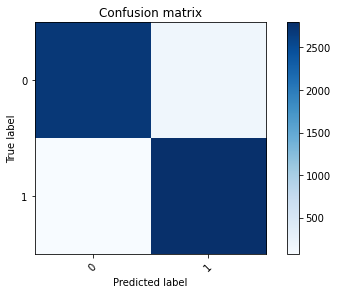

In [ ]:
#CONFUSION MATRIX
cm = confusion_matrix(y_test, y_newpred)
print(cm)
plot_confusion_matrix(cm,['0','1'])  

In [ ]:
# Print classification report
print(metrics.classification_report(y_test, y_newpred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2883
           1       0.94      0.98      0.96      2865

    accuracy                           0.96      5748
   macro avg       0.96      0.96      0.96      5748
weighted avg       0.96      0.96      0.96      5748



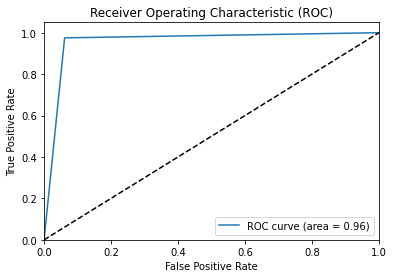

In [ ]:
 #PLOT ROC CURVE
plot_roc(y_newpred,y_test)

### **LOGISTIC REGRESSION**

[[2559  324]
 [  83 2782]]


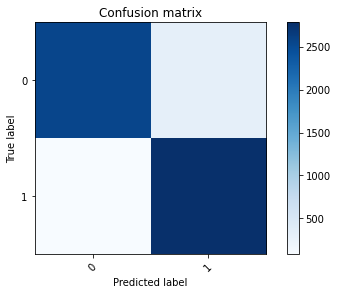

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2883
           1       0.90      0.97      0.93      2865

    accuracy                           0.93      5748
   macro avg       0.93      0.93      0.93      5748
weighted avg       0.93      0.93      0.93      5748



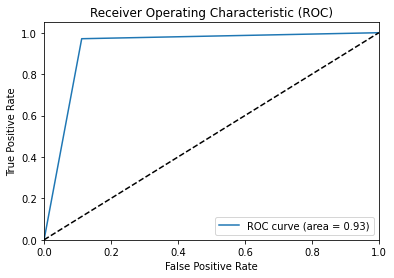

In [ ]:
# instantiate the model 
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response
logreg_pred = logreg.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, logreg_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

#Print classification report
print(metrics.classification_report(y_test, logreg_pred))

#Plot ROC
plot_roc(logreg_pred, y_test)

### **KNN CLASSIFIER**

[[2766  117]
 [  14 2851]]


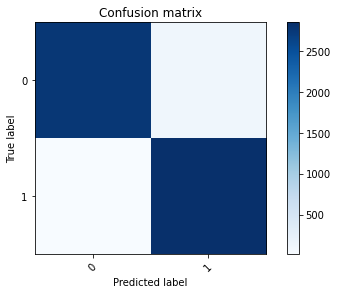

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2883
           1       0.96      1.00      0.98      2865

    accuracy                           0.98      5748
   macro avg       0.98      0.98      0.98      5748
weighted avg       0.98      0.98      0.98      5748



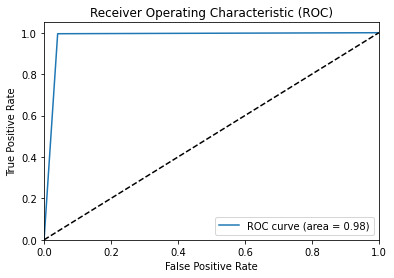

In [ ]:
# instantiate the model (using the value K=3)
knn = KNeighborsClassifier(n_neighbors=3)

# fit the model with data
knn.fit(x_train, y_train)

# predict the response for new observations
knn_pred=knn.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, knn_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()

# Print classification report
print(metrics.classification_report(y_test, knn_pred))

# Plot ROC
plot_roc(knn_pred, y_test)

### **SUPPORT VECTOR MACHINE**

[[2635  248]
 [  55 2810]]


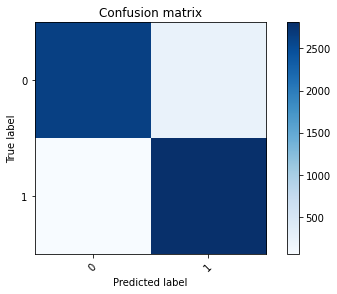

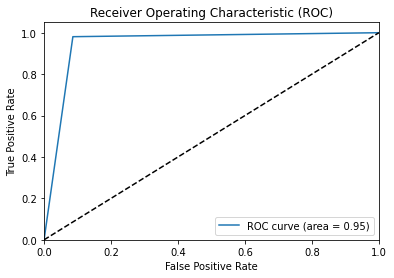

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2883
           1       0.92      0.98      0.95      2865

    accuracy                           0.95      5748
   macro avg       0.95      0.95      0.95      5748
weighted avg       0.95      0.95      0.95      5748



In [ ]:
svm_clf = SVC(probability=True)
svm_clf.fit(x_train,y_train)
svm_pred=svm_clf.predict(x_test)

# Compute the confusion matric
cm = confusion_matrix(y_test, svm_pred)

# Plot confusion matrics
print(cm)
plt.figure()
plot_confusion_matrix(cm, [0,1])
plt.show()


# Plot ROC
plot_roc(svm_pred, y_test)

# Print classification report
print(metrics.classification_report(y_test, svm_pred))

### **CNN**

In [ ]:
x_train_cnn = np.expand_dims(x_train,axis=2)
x_test_cnn = np.expand_dims(x_test, axis=2)

In [ ]:
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train.shape)
print(y_test.shape)

(13412, 74, 1)
(5748, 74, 1)
(13412,)
(5748,)


In [ ]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=4,strides=2,input_shape=(74,1), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".best_weights.hdf5", verbose=0, save_best_only=True)
model.fit(x_train_cnn, y_train,validation_data=(x_test_cnn,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
model.load_weights('.best_weights.hdf5')

model.summary()

Epoch 1/100
420/420 - 2s - loss: 0.2642 - accuracy: 0.8944 - val_loss: 0.1908 - val_accuracy: 0.9328
Epoch 2/100
420/420 - 1s - loss: 0.1893 - accuracy: 0.9332 - val_loss: 0.1596 - val_accuracy: 0.9393
Epoch 3/100
420/420 - 1s - loss: 0.1711 - accuracy: 0.9389 - val_loss: 0.1549 - val_accuracy: 0.9440
Epoch 4/100
420/420 - 1s - loss: 0.1587 - accuracy: 0.9445 - val_loss: 0.1394 - val_accuracy: 0.9497
Epoch 5/100
420/420 - 1s - loss: 0.1501 - accuracy: 0.9498 - val_loss: 0.1448 - val_accuracy: 0.9574
Epoch 6/100
420/420 - 1s - loss: 0.1473 - accuracy: 0.9517 - val_loss: 0.1362 - val_accuracy: 0.9522
Epoch 7/100
420/420 - 1s - loss: 0.1443 - accuracy: 0.9532 - val_loss: 0.1505 - val_accuracy: 0.9497
Epoch 8/100
420/420 - 1s - loss: 0.1418 - accuracy: 0.9542 - val_loss: 0.1274 - val_accuracy: 0.9593
Epoch 9/100
420/420 - 1s - loss: 0.1373 - accuracy: 0.9572 - val_loss: 0.1362 - val_accuracy: 0.9562
Epoch 10/100
420/420 - 1s - loss: 0.1374 - accuracy: 0.9562 - val_loss: 0.1268 - val_accura

[[2726  157]
 [  36 2829]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2883
           1       0.95      0.99      0.97      2865

    accuracy                           0.97      5748
   macro avg       0.97      0.97      0.97      5748
weighted avg       0.97      0.97      0.97      5748

Score_test (RMSE): 0.18323999648483028


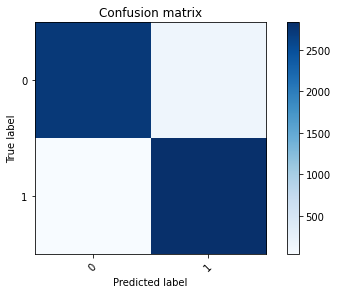

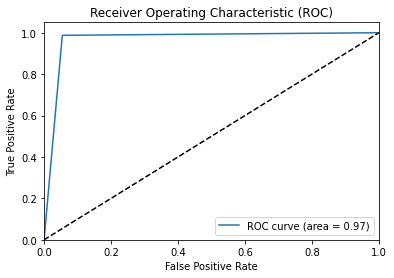

In [ ]:
y_pred = model.predict(x_test_cnn)
y_pred = y_pred.argmax(axis=1)

#CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)

print(cm)
plot_confusion_matrix(cm,['0','1']) 

# Print classification report
print(metrics.classification_report(y_test, y_pred)) 

score_test = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
print("Score_test (RMSE): {}".format(score_test))


#PLOT ROC CURVE
plot_roc(y_pred,y_test)